In [728]:
#Library Imports 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math

In [729]:
#TODO: Ensure this is a safe way of getting the fields/find more automated or uniform way to process fields we want 
fields = ['cve/CVE_data_meta/ID', 'publishedDate', 'cve/problemtype/problemtype_data/0/description/0/value','impact/baseMetricV3/cvssV3/vectorString','impact/baseMetricV3/cvssV3/baseScore','impact/baseMetricV3/cvssV3/baseSeverity']
df = pd.read_csv("recent.csv", skipinitialspace=True, usecols=fields)

#Data Cleanup
dfn = df.rename(columns={'cve/CVE_data_meta/ID': 'CVE', 'publishedDate': 'date', 'cve/problemtype/problemtype_data/0/description/0/value': 'CWEs', 'impact/baseMetricV3/cvssV3/vectorString' :'vectorString','impact/baseMetricV3/cvssV3/baseScore' : 'baseScore', 'impact/baseMetricV3/cvssV3/baseSeverity' : 'baseSeverity' })
dfn['CWEs'] = dfn['CWEs'].fillna(0)
dfn['vectorString'] = dfn['vectorString'].fillna(0)
dfn['baseScore'] = dfn['baseScore'].fillna(0)
dfn['baseSeverity'] = dfn['baseSeverity'].fillna(0)

#Choose Range (currently a small sample) 
dfnew = dfn[190:200]

#View Data
print(dfnew)

                CVE               date    CWEs  \
190  CVE-2020-18171  2021-07-26T20:15Z       0   
191  CVE-2020-18170  2021-07-26T20:15Z       0   
192  CVE-2020-18169  2021-07-26T20:15Z       0   
193  CVE-2020-17952  2021-07-26T20:15Z       0   
194  CVE-2021-32794  2021-07-26T19:15Z       0   
195  CVE-2021-37478  2021-07-26T18:15Z       0   
196  CVE-2021-37477  2021-07-26T18:15Z  CWE-89   
197  CVE-2021-37476  2021-07-26T18:15Z  CWE-89   
198  CVE-2021-37475  2021-07-26T18:15Z  CWE-89   
199  CVE-2021-37473  2021-07-26T18:15Z  CWE-89   

                                     vectorString  baseScore baseSeverity  
190                                             0        0.0            0  
191                                             0        0.0            0  
192                                             0        0.0            0  
193                                             0        0.0            0  
194                                             0        0.0         

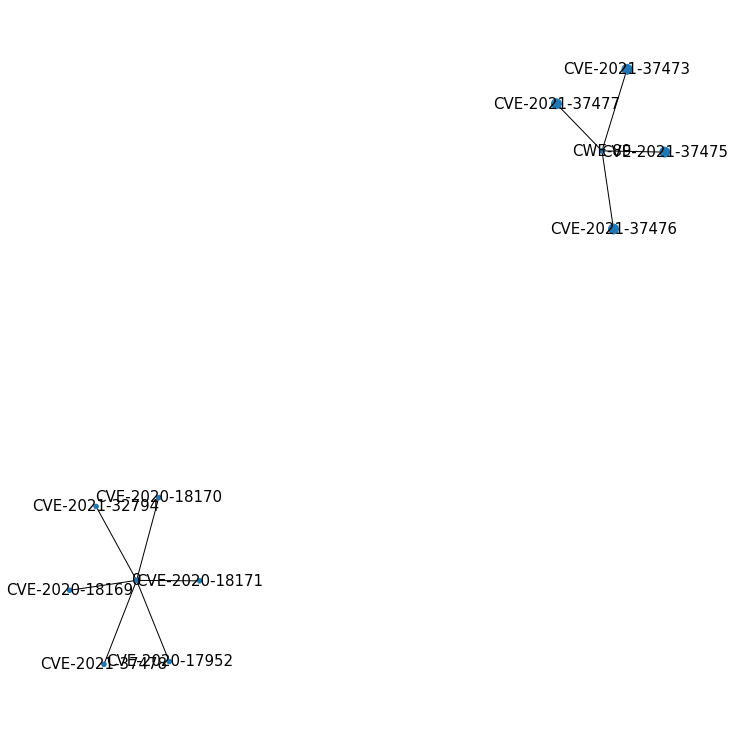

In [730]:
plt.figure(figsize=(10,10))

#Load CSV data into graph 
G = nx.from_pandas_edgelist(dfnew,'CVE', 'CWEs', edge_attr=None)
#Show CVE and CWE data 
#print(G)

#dictionary mapping CVEs to different variables (date, cvss string, risk score, severity score) 
dates = pd.Series(dfnew.date.values, index=dfnew.CVE).to_dict()
vstrings =  pd.Series(dfnew.vectorString.values, index=dfnew.CVE).to_dict()
scores = pd.Series(dfnew.baseScore.values, index=dfnew.CVE).to_dict()
severities = pd.Series(dfnew.baseSeverity.values, index=dfnew.CVE).to_dict()

#add dictionaries to graph as node attributes
nx.set_node_attributes(G, dates, 'date')
nx.set_node_attributes(G, vstrings, 'vstring')
nx.set_node_attributes(G, scores, 'score')
nx.set_node_attributes(G, severities, 'severity')

#verify data was added in nodes
#for i in dict(G.nodes):
 #  print(dict(G.nodes).values())

#Customize node Sizes 
node_sizes = []
node_score = nx.get_node_attributes(G, 'score')
for key in node_score: 
    if (node_score[key] == 0.0):
        node_sizes.append(20.0) 
    if (node_score[key] != 0.0):
        node_sizes.append(node_score[key] * 10) 
        
#Verify node sizes before addition 
#print(node_sizes)

count = 0 
for i in G.nodes: 
    if (G.nodes[i] == {}): 
        node_sizes.insert(count, 20.0) 
    count += 1 
    
#Verify node_sizes were added in proper order 
#print(node_sizes)


#Draw Graph 
nx.draw(G, with_labels=True, node_size = node_sizes, font_size = 15)
plt.show()

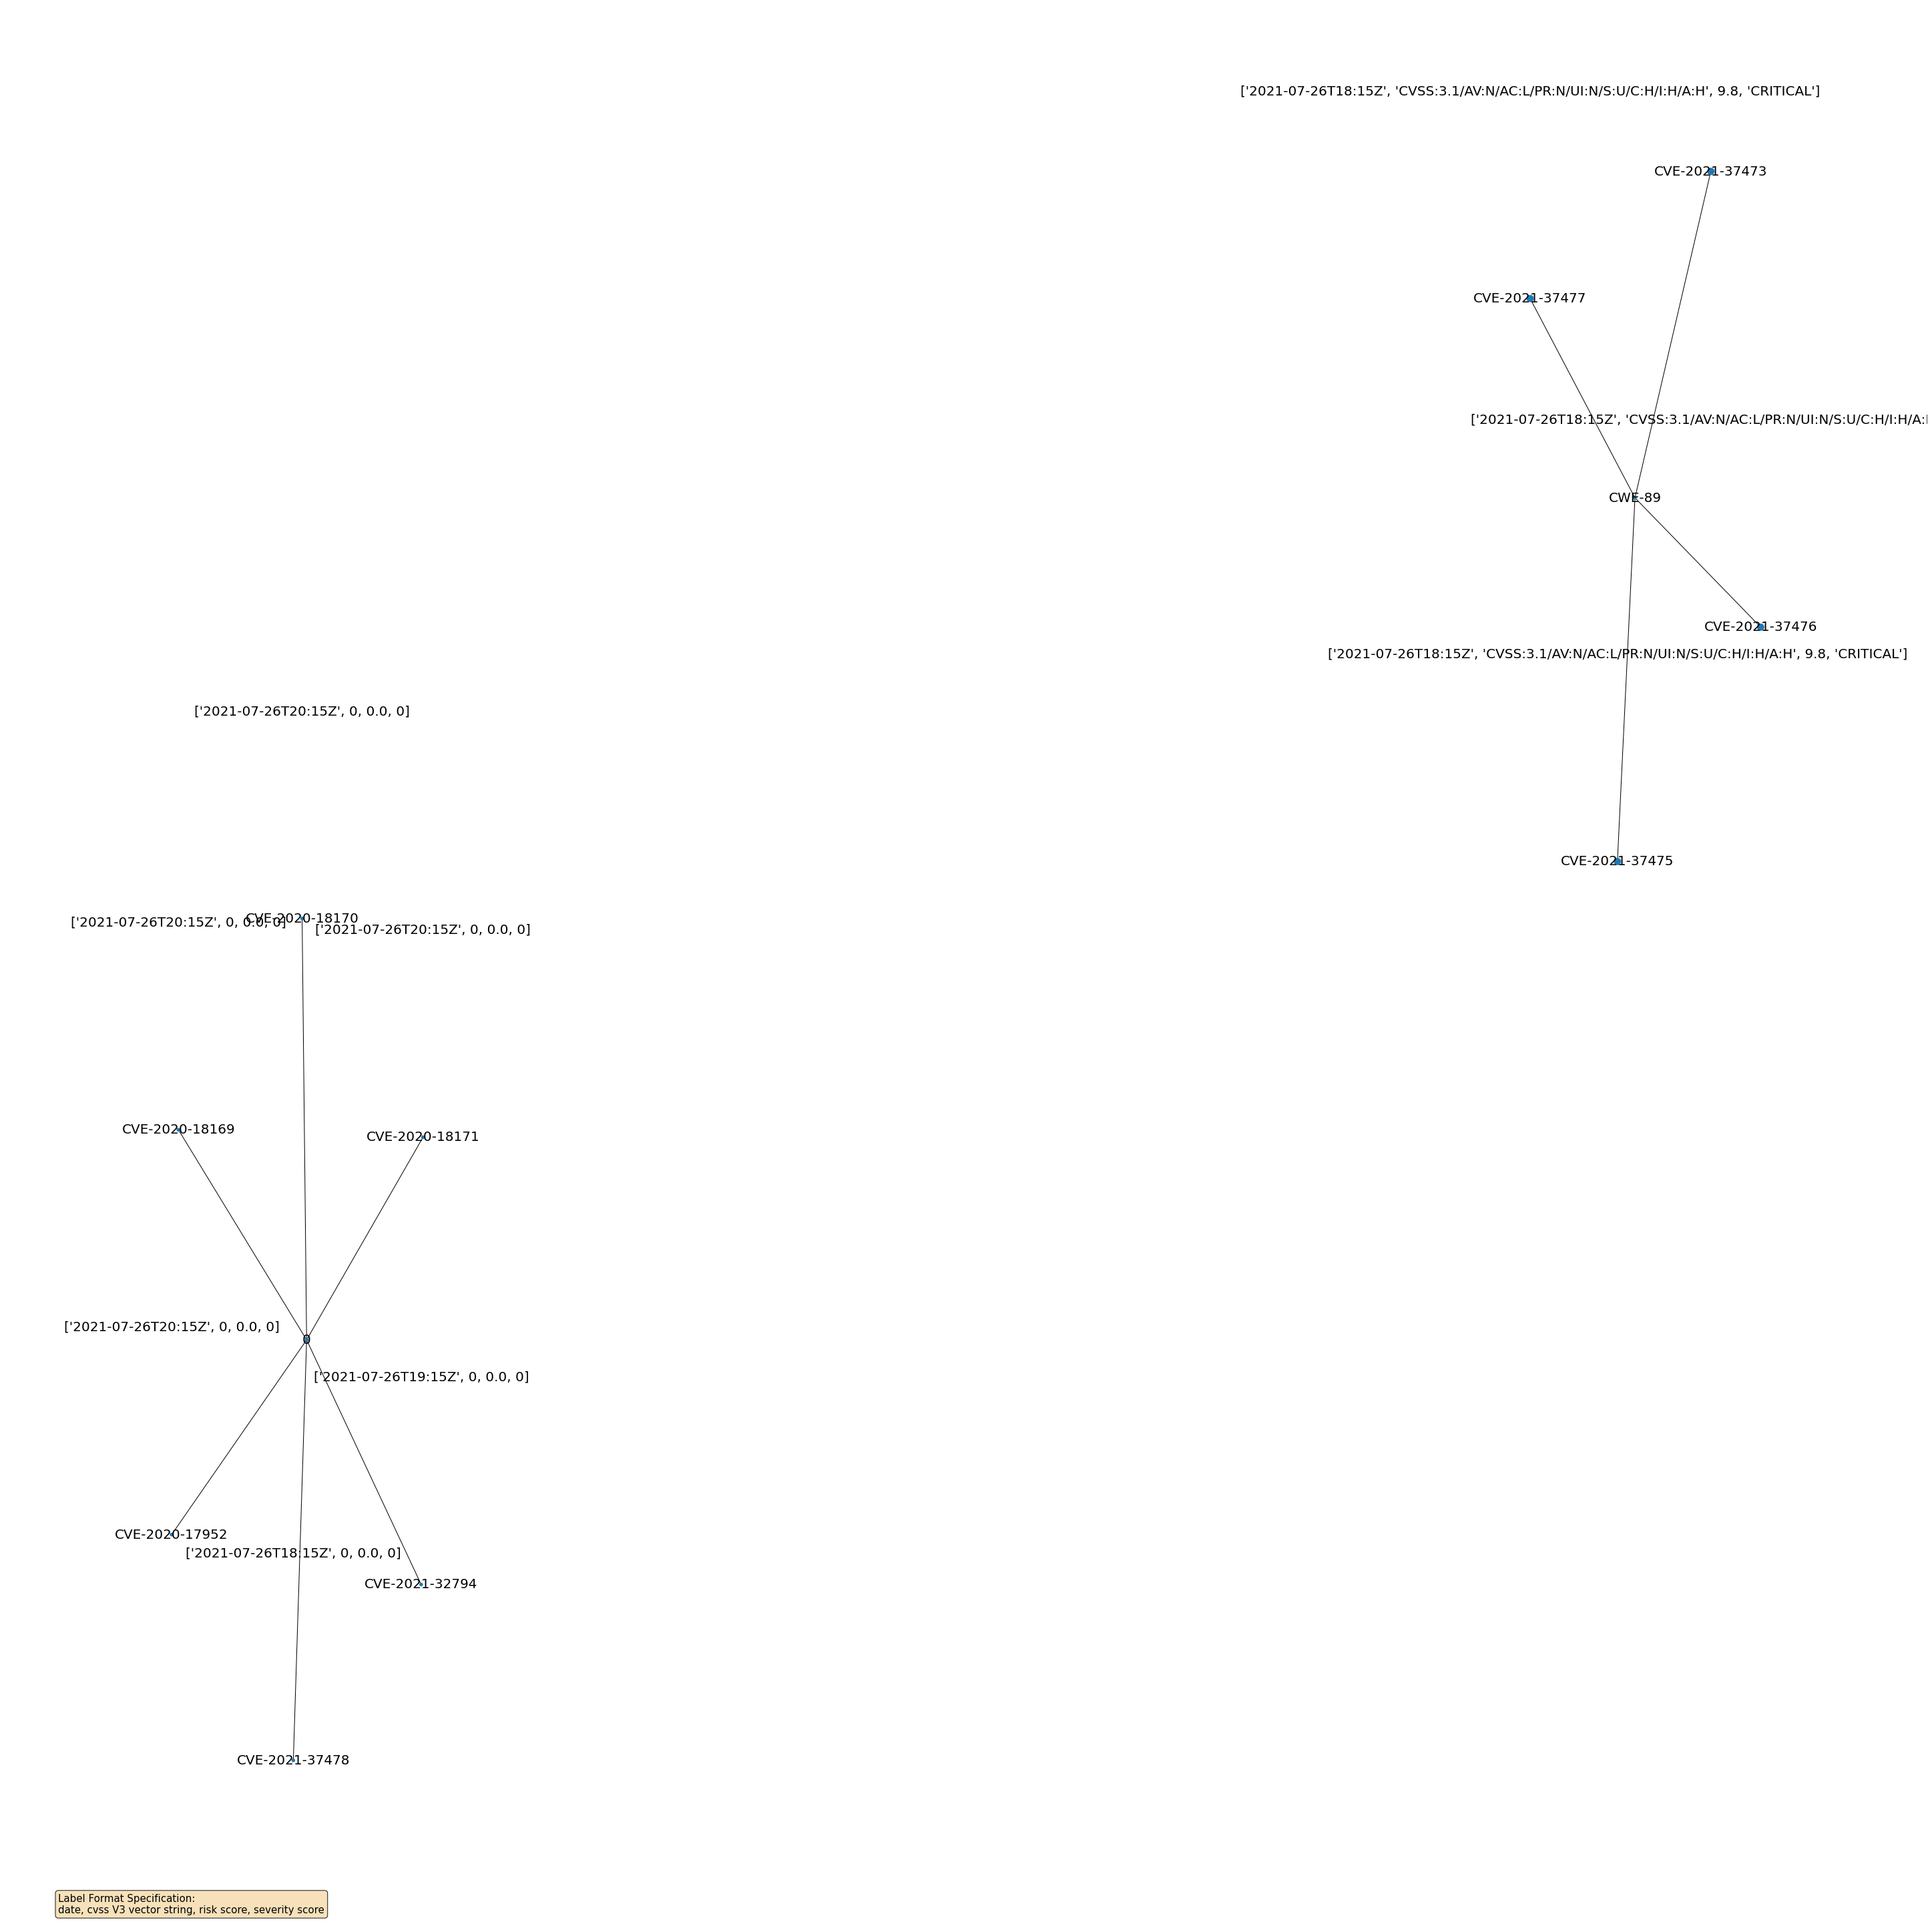

In [731]:
#Plotting Changes
graph_img = plt.figure(figsize=(40,40))
pos_nodes = nx.spring_layout(G)
nx.draw(G, pos_nodes, with_labels=True, node_size = node_sizes, font_size = 20)

#For positioning labels
pos_attrs = {}
for node, coords in pos_nodes.items():
    pos_attrs[node] = (coords[0], coords[1] + 0.08)

#Getting node attributes. Note: Already have node_score from node customization process 
node_date = nx.get_node_attributes(G, 'date')
node_string = nx.get_node_attributes(G, 'vstring')
node_severity = nx.get_node_attributes(G, 'severity')

#Combining all information to add to graph    
combined_dict = {}
attribute_dicts = [node_date, node_string, node_score, node_severity]
for k in attribute_dicts[0]:
    combined_dict[k] = [d[k] for d in attribute_dicts]

#Print Data 
#print(combined_dict) 

#Add to Graph
custom_node_attrs = {}
for node, attr in combined_dict.items():
    custom_node_attrs[node] = attr
    
#Draw Graph
nx.draw_networkx_labels(G, pos_attrs, labels=custom_node_attrs, font_size = 20)


#Add Box Specifying Label Details 
textstr = '\n'.join((
    "Label Format Specification:",
    "date, cvss V3 vector string, risk score, severity score" ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)

plt.text(0.1, 0.1, textstr, fontsize=15,
        verticalalignment='top', bbox=props, transform=ax.transAxes)


plt.show()
#Save Figure as Image if needed/to share
graph_img.savefig('graph.png')